# Support Vector Machines (SVM) Tutorial
This notebook demonstrates the use of Support Vector Machines (SVM) with different kernels on the Iris dataset, showcasing the effects of kernel choice on performance.

## Step 1: Introduction to SVM
<li>Support Vector Machines (SVM) are powerful supervised learning algorithms used for both classification and regression tasks.</li> 
<li>SVMs find the optimal hyperplane that separates data points of different classes.</li>
<li>When data is not linearly separable, kernels are used to map data into higher dimensions for better separation.</li>


In [22]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


## Step 2: Loading and Exploring the Iris Dataset
<li>The Iris dataset contains 150 samples with four features each, classified into three species of flowers: </li>
<li> Setosa, Versicolor, and Virginica.</li>


In [23]:
# Load the Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="Species")

# Dataset Overview
print("Dataset Overview:")
print(X.describe())

Dataset Overview:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


## Step 3: Data Preprocessing

Scaling the features to ensure SVM performance is not biased by feature magnitude.


In [24]:
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


## Step 4: Exploring Different Kernels

SVM Kernels allow non-linear data separation by transforming the feature space.


In [25]:
kernels = ['linear', 'poly', 'rbf']
results = []

for kernel in kernels:
    # Constructing the parameter grid based on the kernel
    param_grid = {'C': [0.1, 1, 10]}  # 'C' is applicable to all kernels
    
    if kernel == 'poly':
        param_grid['degree'] = [2, 3, 4]  # Only applicable to polynomial kernel
        param_grid['gamma'] = ['scale', 'auto']  # Also applicable to poly
    elif kernel == 'rbf':
        param_grid['gamma'] = ['scale', 'auto']  # Only applicable to RBF kernel

    # Running GridSearchCV
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Collecting results
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    results.append({
        "kernel": kernel,
        "best_params": grid_search.best_params_,
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": cm
    })


## Step 5: Visualizing Results

Displaying confusion matrices for each kernel.

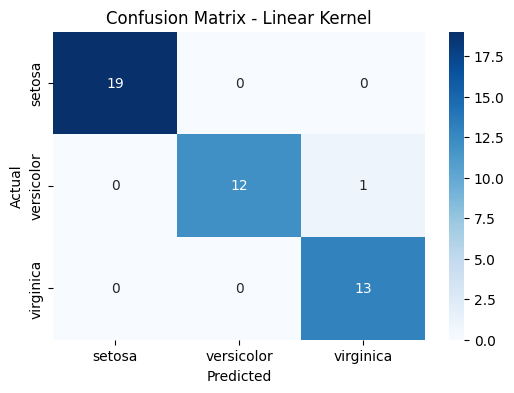

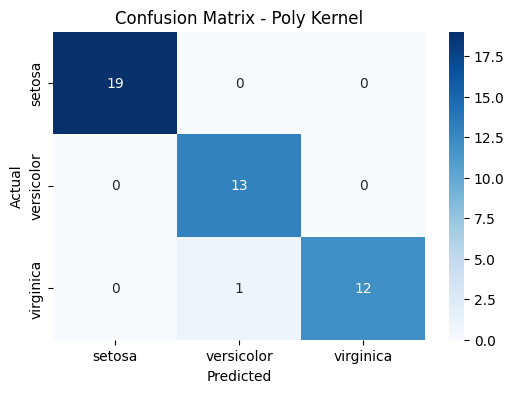

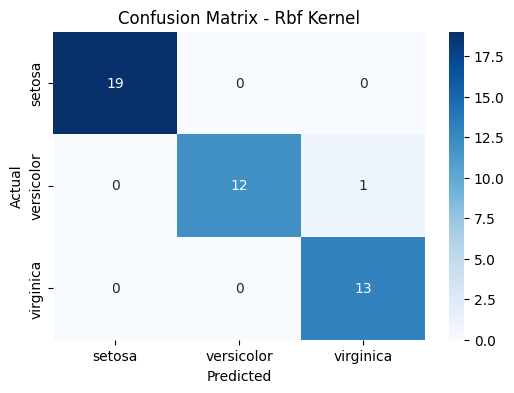

In [26]:
for result in results:
    kernel = result["kernel"]
    cm = result["confusion_matrix"]

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
    plt.title(f'Confusion Matrix - {kernel.capitalize()} Kernel')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


## Step 6: Analyzing Results

Summary table showing the best parameters and accuracy for each kernel.


In [27]:
# Creating the summary DataFrame
# Creating the summary DataFrame
summary = pd.DataFrame({
    "Kernel": [result["kernel"] for result in results],
    "Best Params": [result["best_params"] for result in results],
    "Accuracy": [result["accuracy"] for result in results]
})


# Display the summary DataFrame as a table
display(summary)

,Kernel,Best Params,Accuracy
0,linear,{'C': 1},0.977778
1,poly,"{'C': 10, 'degree': 3, 'gamma': 'scale'}",0.977778
2,rbf,"{'C': 10, 'gamma': 'auto'}",0.977778


## Step 7: Feature Importance (Linear Kernel)

Analyzing feature importance for the linear kernel using its coefficients.

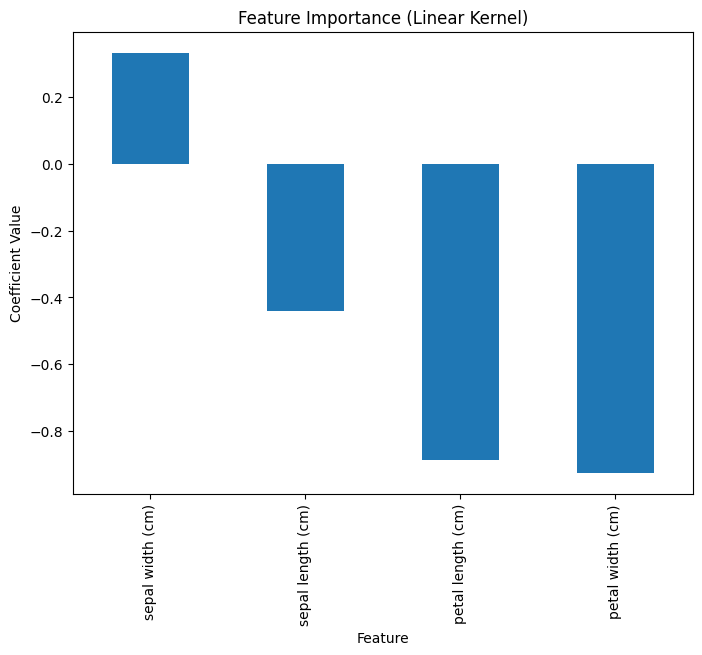

In [28]:
linear_model = SVC(kernel='linear', C=1).fit(X_train, y_train)
feature_importance = pd.Series(data=linear_model.coef_[0], index=iris.feature_names)
feature_importance.sort_values(ascending=False, inplace=True)

# Plotting feature importance
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance (Linear Kernel)")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.show()

## Step 8: Visualizing Support Vectors

Highlighting the support vectors on a PCA-reduced 2D plot.


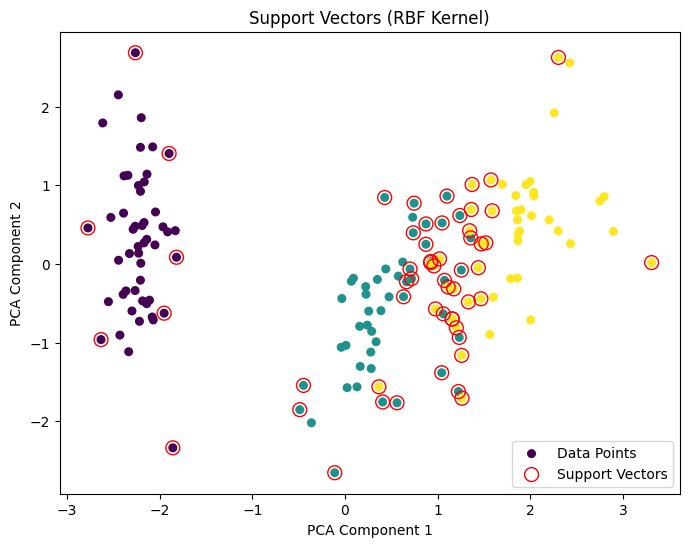

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

svm_rbf = SVC(kernel='rbf', C=1).fit(X_pca, y)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=30, label='Data Points')
plt.scatter(svm_rbf.support_vectors_[:, 0], svm_rbf.support_vectors_[:, 1], 
            s=100, facecolors='none', edgecolors='r', label='Support Vectors')
plt.title("Support Vectors (RBF Kernel)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

## Step 9: Sensitivity Analysis for C and Gamma

Analyzing how SVM performance varies with different values of C and gamma.


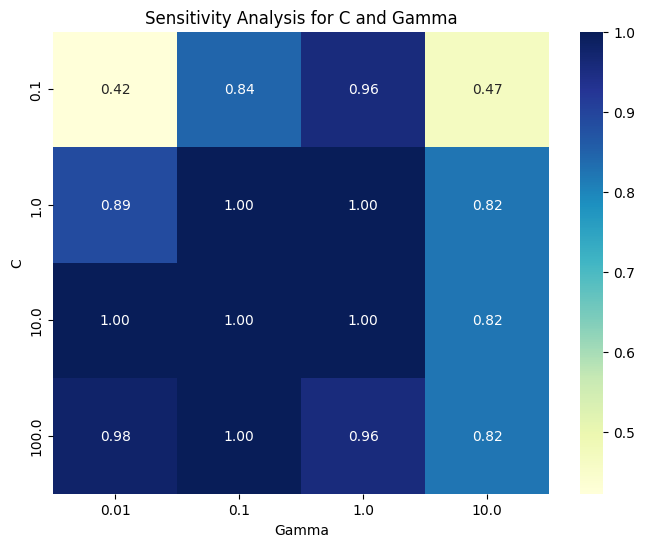

In [31]:
C_values = [0.1, 1, 10, 100]
gamma_values = [0.01, 0.1, 1, 10]
results_sensitivity = []

for C in C_values:
    for gamma in gamma_values:
        svm_model = SVC(kernel='rbf', C=C, gamma=gamma)
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results_sensitivity.append({"C": C, "Gamma": gamma, "Accuracy": acc})

# Convert results to a DataFrame
sensitivity_df = pd.DataFrame(results_sensitivity)

# Create a pivot table for heatmap visualization
pivot_table = sensitivity_df.pivot_table(index="C", columns="Gamma", values="Accuracy")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Sensitivity Analysis for C and Gamma")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()


# Explanation:

# Support Vector Machines (SVM) Tutorial: Understanding Kernels and Their Impact on Performance

---

## **1. Introduction to SVM**
Support Vector Machines (SVM) are powerful supervised learning algorithms used for classification and regression tasks. They work by finding the optimal hyperplane that separates data points from different classes with the maximum margin.

### **Why Use Kernels?**
When data is not linearly separable, kernels map the data into a higher-dimensional space where a linear separation is possible. Common kernels include:
- **Linear Kernel:** Suitable for linearly separable data.
- **Polynomial Kernel:** Maps data into polynomial feature space.
- **RBF (Radial Basis Function) Kernel:** Captures complex relationships in non-linear data.

---

## **2. Dataset Overview**
The Iris dataset is used for this tutorial:
- **Features:** Sepal length, Sepal width, Petal length, Petal width.
- **Classes:** Setosa, Versicolor, Virginica.

The dataset has 150 samples, evenly distributed across the three species. It is widely used for benchmarking classification algorithms.

---

## **3. Data Preprocessing**
### Why Scale Features?
SVMs are sensitive to the magnitude of features. Feature scaling ensures all features contribute equally to the model’s performance.

### Steps:
- Standardize features using `StandardScaler`.
- Split the dataset into training (70%) and testing (30%) subsets.

---

## **4. Exploring Different Kernels**
### Objective:
Evaluate the performance of SVM using different kernels:
- **Linear**
- **Polynomial**
- **RBF**

### Method:
- Use `GridSearchCV` for hyperparameter tuning.
- Evaluate models on test data.
- Collect metrics:
  - Accuracy
  - Classification Report
  - Confusion Matrix

---

## **5. Visualizing Results**
Confusion matrices are visualized using heatmaps to show the performance of each kernel. This helps in identifying misclassifications.

---

## **6. Analyzing Results**
A summary table provides:
- Best parameters for each kernel.
- Accuracy scores for comparison.

This makes it easier to identify which kernel performs best for the given dataset.

---

## **7. Feature Importance (Linear Kernel)**
### Why Analyze Feature Importance?
For the linear kernel, the coefficients of the hyperplane indicate the importance of each feature.

### Visualization:
A bar plot shows the relative importance of each feature, highlighting which features contribute most to classification.

---

## **8. Visualizing Support Vectors**
### Why Visualize Support Vectors?
Support vectors are the critical data points that influence the decision boundary.

### Method:
- Use PCA to reduce data to 2D.
- Plot data points and highlight support vectors.

This visualization demonstrates how SVM relies on a subset of the training data to make predictions.

---

## **9. Sensitivity Analysis for \(C\) and \(\gamma\)**
### What are \(C\) and \(\gamma\)?
- **C (Regularization):** Controls the trade-off between maximizing margin and minimizing misclassification.
- **\(\gamma\) (Kernel Coefficient):** Determines the influence of individual data points in RBF and polynomial kernels.

### Visualization:
A heatmap shows the accuracy for different combinations of \(C\) and \(\gamma\), helping to identify the optimal hyperparameters.

---

## **Key Takeaways**
1. **Kernel Comparison:**
   - Linear kernels are effective for linearly separable data.
   - RBF and polynomial kernels excel at handling non-linear data, with RBF often being more flexible.

2. **Feature Importance:**
   - Linear kernels reveal which features are most influential in classification.

3. **Support Vectors:**
   - SVM relies on a small subset of critical data points, ensuring robustness to outliers.

4. **Hyperparameter Sensitivity:**
   - Model performance depends on selecting appropriate \(C\) and \(\gamma\). Systematic experimentation (e.g., GridSearchCV) is essential.

---

## **Advanced Insights**
- **Practical Usage:**
  - Use linear kernels for high-dimensional sparse data.
  - RBF kernels are ideal for datasets with complex, non-linear patterns.
- **Visualization Techniques:**
  - PCA and t-SNE can be used for intuitive visualizations of high-dimensional data.
- **Cross-Validation:**
  - Ensures robust evaluation, preventing overfitting and underfitting.

---

## **Conclusion**
This tutorial provides a step-by-step guide to understanding and applying SVM. Through detailed analyses and visualizations:
- You’ve seen the impact of different kernels on performance.
- Understood the importance of hyperparameter tuning.
- Learned how SVM identifies critical support vectors.

This knowledge equips you to use SVM effectively for classification tasks and adapt it to different datasets.
